# Weight Initialization
In this lesson, you'll learn how to find good initial weights for a neural network. Having good initial weights can place the neural network close to the optimal solution. This allows the neural network to come to the best solution quicker. 

## Testing Weights
### Dataset
To see how different weights perform, we'll test on the same dataset and neural network. Let's go over the dataset and neural network.

We'll be using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) to demonstrate the different initial weights. As a reminder, the MNIST dataset contains images of handwritten numbers, 0-9, with normalized input (0.0 - 1.0).  Run the cell below to download and load the MNIST dataset.

In [1]:
%matplotlib inline

import tensorflow as tf
import helper

from tensorflow.examples.tutorials.mnist import input_data

print('Getting MNIST Dataset...')
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print('Data Extracted.')

Getting MNIST Dataset...
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Data Extracted.


### Neural Network
<img style="float: left" src="images/neural_network.png"/>

For the neural network, we'll test on a 3 layer neural network with ReLU activations and an Adam optimizer.  The lessons you learn apply to other neural networks, including different activations and optimizers.

In [2]:
# Save the shapes of weights for each layer
layer_1_weight_shape = (mnist.train.images.shape[1], 256)
layer_2_weight_shape = (256, 128)
layer_3_weight_shape = (128, mnist.train.labels.shape[1])

## Initialize Weights
Let's start looking at some initial weights.
### All Zeros or Ones
If you follow the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor), you might think setting all the weights to 0 or 1 would be the best solution.  This is not the case.

With every weight the same, all the neurons at each layer are producing the same output.  This makes it hard to decide which weights to adjust.

Let's compare the loss with all ones and all zero weights using `helper.compare_init_weights`.  This function will run two different initial weights on the neural network above for 2 epochs.  It will plot the loss for the first 100 batches and print out stats after the 2 epochs (~860 batches). We plot the first 100 batches to better judge which weights performed better at the start.

Run the cell below to see the difference between weights of all zeros against all ones.

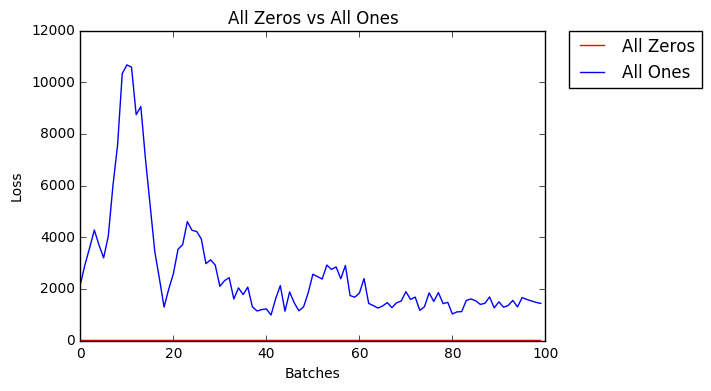

After 858 Batches (2 Epochs):
Validation Accuracy
   11.260% -- All Zeros
    9.240% -- All Ones
Loss
    2.304  -- All Zeros
  251.097  -- All Ones


In [3]:
all_zero_weights = [
    tf.Variable(tf.zeros(layer_1_weight_shape)),
    tf.Variable(tf.zeros(layer_2_weight_shape)),
    tf.Variable(tf.zeros(layer_3_weight_shape))
]

all_one_weights = [
    tf.Variable(tf.ones(layer_1_weight_shape)),
    tf.Variable(tf.ones(layer_2_weight_shape)),
    tf.Variable(tf.ones(layer_3_weight_shape))
]

helper.compare_init_weights(
    mnist,
    'All Zeros vs All Ones',
    [
        (all_zero_weights, 'All Zeros'),
        (all_one_weights, 'All Ones')])

As you can see the accuracy is close to guessing for both zeros and ones, around 10%.

The neural network is having a hard time determining which weights need to be changed, since the neurons have the same output for each layer.  To avoid neurons with the same output, let's use unique weights.  We can also randomly select these weights to avoid being stuck in a local minimum for each run.

A good solution for getting these random weights is to sample from a uniform distribution.

### Uniform Distribution
A [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous%29) has the equal probability of picking any number from a set of numbers. We'll be picking from a continous distribution, so the chance of picking the same number is low. We'll use TensorFlow's `tf.random_uniform` function to pick random numbers from a uniform distribution.

>#### [`tf.random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)`](https://www.tensorflow.org/api_docs/python/tf/random_uniform)
>Outputs random values from a uniform distribution.

>The generated values follow a uniform distribution in the range [minval, maxval). The lower bound minval is included in the range, while the upper bound maxval is excluded.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **minval:** A 0-D Tensor or Python value of type dtype. The lower bound on the range of random values to generate. Defaults to 0.
- **maxval:** A 0-D Tensor or Python value of type dtype. The upper bound on the range of random values to generate. Defaults to 1 if dtype is floating point.
- **dtype:** The type of the output: float32, float64, int32, or int64.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

We can visualize the uniform distribution by using a histogram. Let's map the values from `tf.random_uniform([1000], -3, 3)` to a histogram using the `helper.hist_dist` function. This will be `1000` random float values from `-3` to `3`, excluding the value `3`.

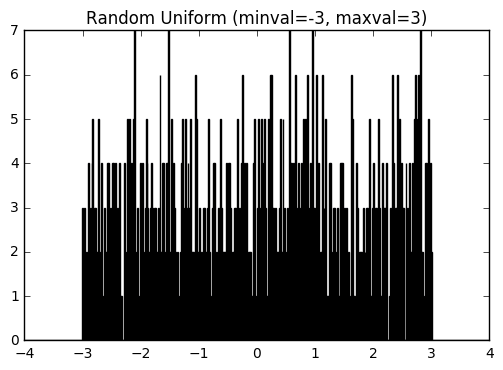

In [4]:
helper.hist_dist('Random Uniform (minval=-3, maxval=3)', tf.random_uniform([1000], -3, 3))

The histogram used 500 buckets for the 1000 values.  Since the chance for any single bucket is the same, there should be around 2 values for each bucket. That's exactly what we see with the histogram.  Some buckets have more and some have less, but they trend around 2.

Now that you understand the `tf.random_uniform` function, let's apply it to some initial weights.

### Baseline


Let's see how well the neural network trains using the default values for `tf.random_uniform`, where `minval=0.0` and `maxval=1.0`.

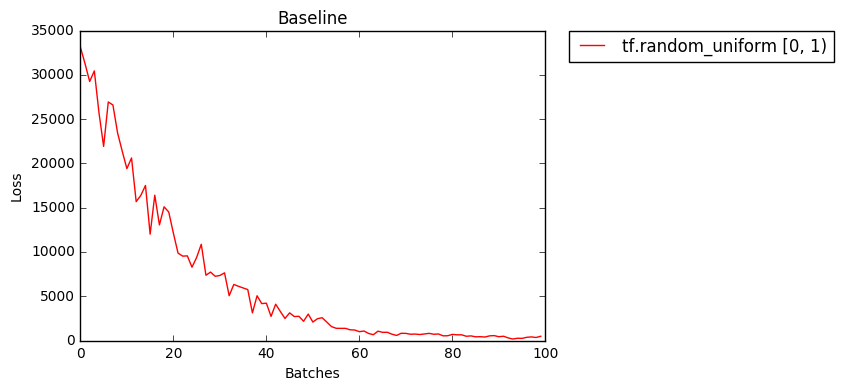

After 858 Batches (2 Epochs):
Validation Accuracy
   75.120% -- tf.random_uniform [0, 1)
Loss
   21.768  -- tf.random_uniform [0, 1)


In [5]:
# Default for tf.random_uniform is minval=0 and maxval=1
basline_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape))
]

helper.compare_init_weights(
    mnist,
    'Baseline',
    [(basline_weights, 'tf.random_uniform [0, 1)')])

The loss graph is showing the neural network is learning, which it didn't with all zeros or all ones. We're headed in the right direction.

### General rule for setting weights
The general rule for setting the weights in a neural network is to be close to zero without being too small. A good pracitce is to start your weights in the range of $[-y, y]$ where
$y=1/\sqrt{n}$ ($n$ is the number of inputs to a given neuron).

Let's see if this holds true, let's first center our range over zero.  This will give us the range [-1, 1).

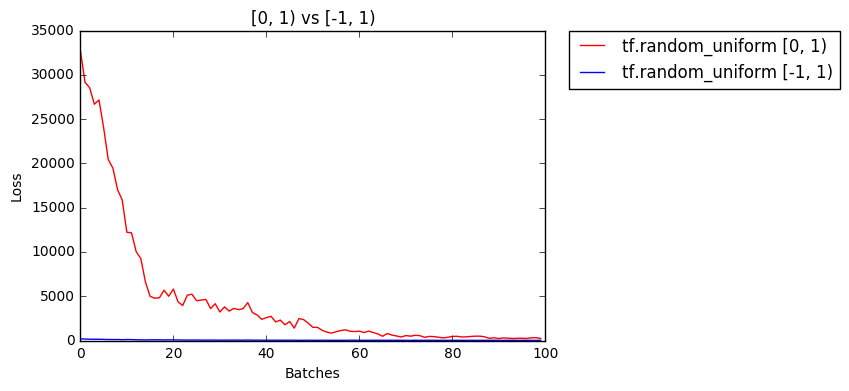

After 858 Batches (2 Epochs):
Validation Accuracy
   80.320% -- tf.random_uniform [0, 1)
   90.360% -- tf.random_uniform [-1, 1)
Loss
   22.896  -- tf.random_uniform [0, 1)
    2.213  -- tf.random_uniform [-1, 1)


In [6]:
uniform_neg1to1_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -1, 1)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -1, 1)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -1, 1))
]

helper.compare_init_weights(
    mnist,
    '[0, 1) vs [-1, 1)',
    [
        (basline_weights, 'tf.random_uniform [0, 1)'),
        (uniform_neg1to1_weights, 'tf.random_uniform [-1, 1)')])

We're going in the right direction, the accuracy and loss is better with [-1, 1). We still want smaller weights. How far can we go before it's too small?

### Too small
Let's compare [-0.1, 0.1), [-0.01, 0.01), and [-0.001, 0.001) to see how small is too small.  We'll also set `plot_n_batches=None` to show all the batches in the plot.

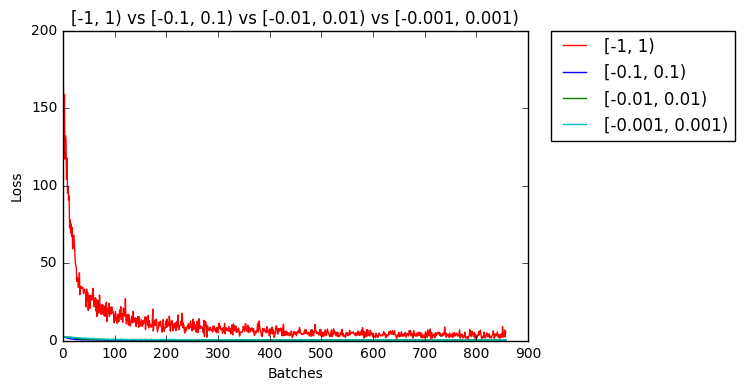

After 858 Batches (2 Epochs):
Validation Accuracy
   90.920% -- [-1, 1)
   96.740% -- [-0.1, 0.1)
   95.620% -- [-0.01, 0.01)
   93.860% -- [-0.001, 0.001)
Loss
    5.882  -- [-1, 1)
    0.181  -- [-0.1, 0.1)
    0.254  -- [-0.01, 0.01)
    0.156  -- [-0.001, 0.001)


In [7]:
uniform_neg01to01_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.1, 0.1)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.1, 0.1)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.1, 0.1))
]

uniform_neg001to001_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.01, 0.01)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.01, 0.01)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.01, 0.01))
]

uniform_neg0001to0001_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.001, 0.001)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.001, 0.001)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.001, 0.001))
]

helper.compare_init_weights(
    mnist,
    '[-1, 1) vs [-0.1, 0.1) vs [-0.01, 0.01) vs [-0.001, 0.001)',
    [
        (uniform_neg1to1_weights, '[-1, 1)'),
        (uniform_neg01to01_weights, '[-0.1, 0.1)'),
        (uniform_neg001to001_weights, '[-0.01, 0.01)'),
        (uniform_neg0001to0001_weights, '[-0.001, 0.001)')],
    plot_n_batches=None)

Looks like anything [-0.01, 0.01) or smaller is too small.  Let's compare this to our typical rule of using the range $y=1/\sqrt{n}$.

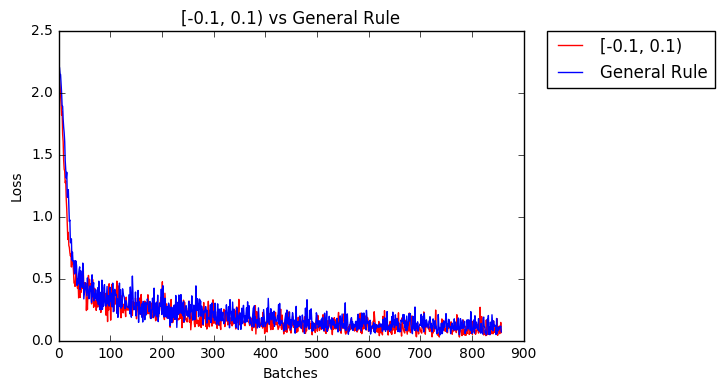

After 858 Batches (2 Epochs):
Validation Accuracy
   97.020% -- [-0.1, 0.1)
   96.760% -- General Rule
Loss
    0.064  -- [-0.1, 0.1)
    0.070  -- General Rule


In [8]:
import numpy as np

general_rule_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -1/np.sqrt(layer_1_weight_shape[0]), 1/np.sqrt(layer_1_weight_shape[0]))),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -1/np.sqrt(layer_2_weight_shape[0]), 1/np.sqrt(layer_2_weight_shape[0]))),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -1/np.sqrt(layer_3_weight_shape[0]), 1/np.sqrt(layer_3_weight_shape[0])))
]

helper.compare_init_weights(
    mnist,
    '[-0.1, 0.1) vs General Rule',
    [
        (uniform_neg01to01_weights, '[-0.1, 0.1)'),
        (general_rule_weights, 'General Rule')],
    plot_n_batches=None)

The range we found and $y=1/\sqrt{n}$ are really close.

Since the uniform distribution has the same chance to pick anything in the range, what if we used a distribution that had a higher chance of picking numbers closer to 0.  Let's look at the normal distribution.
### Normal Distribution
Unlike the uniform distribution, the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) has a higher likelihood of picking number close to it's mean. To visualize it, let's plot values from TensorFlow's `tf.random_normal` function to a histogram.

>[tf.random_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)](https://www.tensorflow.org/api_docs/python/tf/random_normal)

>Outputs random values from a normal distribution.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **mean:** A 0-D Tensor or Python value of type dtype. The mean of the normal distribution.
- **stddev:** A 0-D Tensor or Python value of type dtype. The standard deviation of the normal distribution.
- **dtype:** The type of the output.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

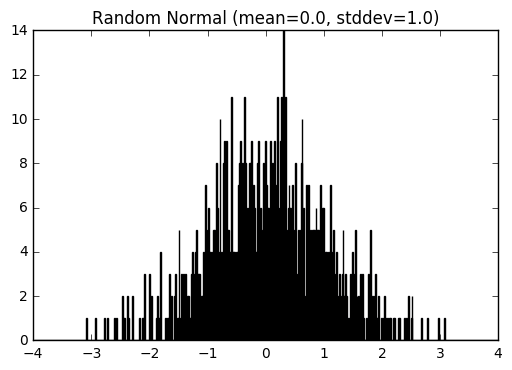

In [9]:
helper.hist_dist('Random Normal (mean=0.0, stddev=1.0)', tf.random_normal([1000]))

Let's compare the normal distribution against the previous uniform distribution.

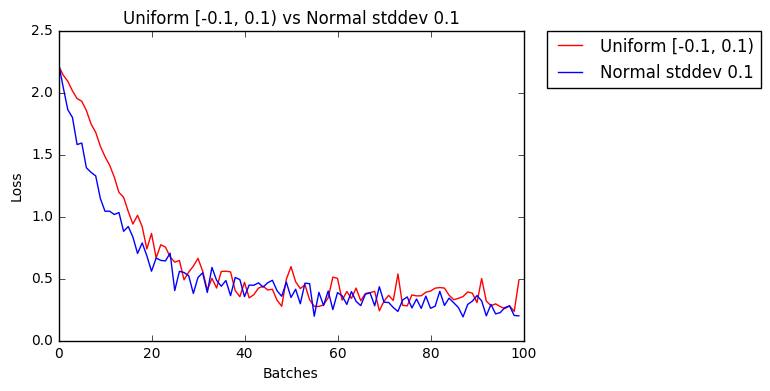

After 858 Batches (2 Epochs):
Validation Accuracy
   97.480% -- Uniform [-0.1, 0.1)
   97.000% -- Normal stddev 0.1
Loss
    0.108  -- Uniform [-0.1, 0.1)
    0.152  -- Normal stddev 0.1


In [10]:
normal_01_weights = [
    tf.Variable(tf.random_normal(layer_1_weight_shape, stddev=0.1)),
    tf.Variable(tf.random_normal(layer_2_weight_shape, stddev=0.1)),
    tf.Variable(tf.random_normal(layer_3_weight_shape, stddev=0.1))
]

helper.compare_init_weights(
    mnist,
    'Uniform [-0.1, 0.1) vs Normal stddev 0.1',
    [
        (uniform_neg01to01_weights, 'Uniform [-0.1, 0.1)'),
        (normal_01_weights, 'Normal stddev 0.1')])

The normal distribution gave a slight increasse in accuracy and loss.  Let's move closer to 0 and drop picked numbers that are `x` number of standard deviations away.  This distribution is called [Truncated Normal Distribution](https://en.wikipedia.org/wiki/Truncated_normal_distribution%29).
### Truncated Normal Distribution
>[tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)](https://www.tensorflow.org/api_docs/python/tf/truncated_normal)

>Outputs random values from a truncated normal distribution.

>The generated values follow a normal distribution with specified mean and standard deviation, except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **mean:** A 0-D Tensor or Python value of type dtype. The mean of the truncated normal distribution.
- **stddev:** A 0-D Tensor or Python value of type dtype. The standard deviation of the truncated normal distribution.
- **dtype:** The type of the output.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

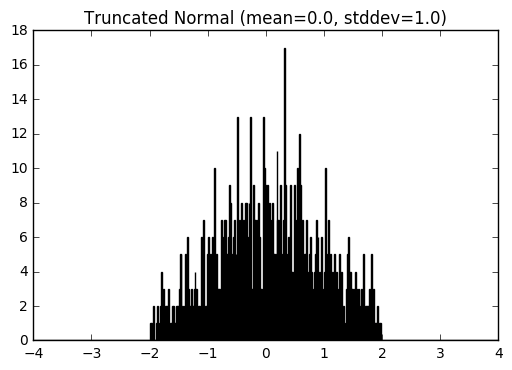

In [11]:
helper.hist_dist('Truncated Normal (mean=0.0, stddev=1.0)', tf.truncated_normal([1000]))

Again, let's compare the previous results with the previous distribution.

In [ ]:
trunc_normal_01_weights = [
    tf.Variable(tf.truncated_normal(layer_1_weight_shape, stddev=0.1)),
    tf.Variable(tf.truncated_normal(layer_2_weight_shape, stddev=0.1)),
    tf.Variable(tf.truncated_normal(layer_3_weight_shape, stddev=0.1))
]

helper.compare_init_weights(
    mnist,
    'Normal vs Truncated Normal',
    [
        (normal_01_weights, 'Normal'),
        (trunc_normal_01_weights, 'Truncated Normal')])

There's no difference between the two, but that's because the neural network we're using is too small. A larger neural network will pick more points on the normal distribution, increasing the likelihood it's choices are larger than 2 standard deviations.

We've come a long way from the first set of weights we tested. Let's see the difference between the weights we used then and now.

In [ ]:
helper.compare_init_weights(
    mnist,
    'Baseline vs Truncated Normal',
    [
        (basline_weights, 'Baseline'),
        (trunc_normal_01_weights, 'Truncated Normal')])

That's a huge difference. You can barely see the truncated normal line.  However, this is not the end your learning path.  We've provided more resources for initializing weights in the classroom!